The file smalldigits.csv contains 1797 8x8 images of hand written digits (modified from the sklearn digits
dataset). Note the data here is low resolution and has been binarised for this example. Each row of the
file has 65 elements: the first 64 are 0/1 values indicating the pixel value, and the last element is the class
number (0-9). To visualise the nth digit, reshape the nth row into an 8x8 matrix

Train a NB classifier on a random 80% of the data, and use the remaining 20% to generate a confusion
matrix showing its performance

In [115]:
# Tools:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

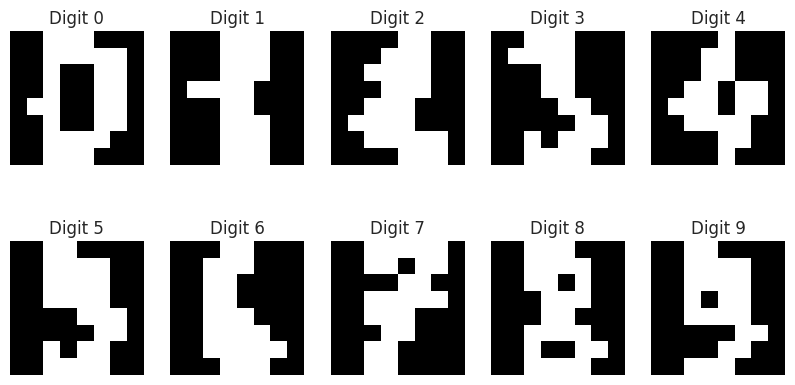

In [116]:
# Data:
data = pd.read_csv('smalldigits.csv', header=None)

# Visualise the first 10 digits:
fig, ax = plt.subplots(2, 5, figsize=(10, 5))
for i in range(10):
    ax[i // 5, i % 5].imshow(data.iloc[i, :-1].values.reshape(8, 8), cmap='gray')
    ax[i // 5, i % 5].set_title('Digit {}'.format(data.iloc[i, -1]))
    ax[i // 5, i % 5].axis('off')
plt.show()

Data shape: (1797, 65)
Data types: int64    65
dtype: int64
Data nulls: 0
Data unique values: 129
Data class distribution: 3    183
1    182
5    182
4    181
6    181
9    180
7    179
0    178
2    177
8    174
Name: 64, dtype: int64


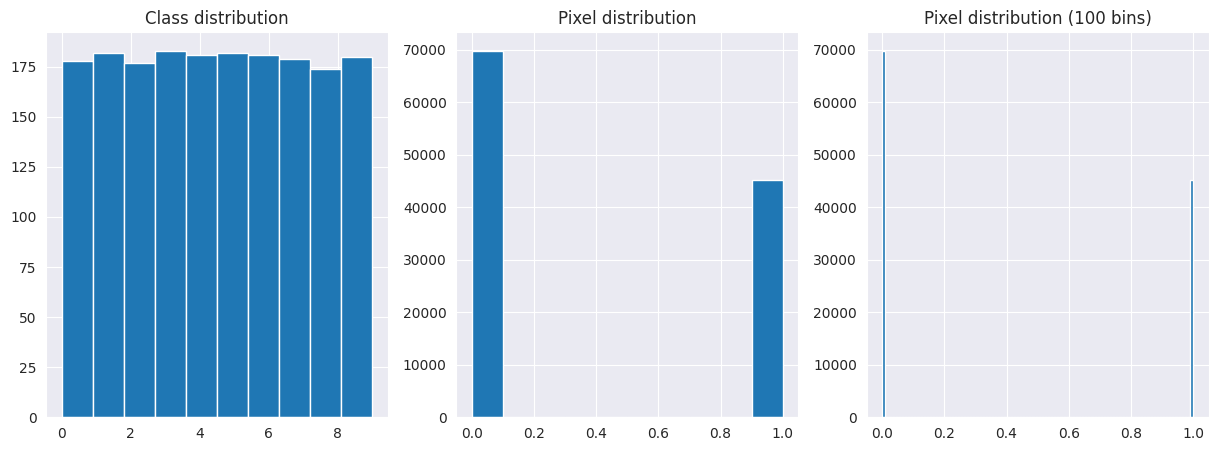

In [117]:
# Data diagnostics:
print('Data shape: {}'.format(data.shape))
print('Data types: {}'.format(data.dtypes.value_counts()))
print('Data nulls: {}'.format(data.isnull().sum().sum()))
print('Data unique values: {}'.format(data.nunique().sum()))
print('Data class distribution: {}'.format(data.iloc[:, -1].value_counts()))

# Graph the data diagnostics:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(data.iloc[:, -1])
ax[0].set_title('Class distribution')
ax[1].hist(data.iloc[:, :-1].values.reshape(-1))
ax[1].set_title('Pixel distribution')
ax[2].hist(data.iloc[:, :-1].values.reshape(-1), bins=100)
ax[2].set_title('Pixel distribution (100 bins)')
plt.show()

**split_data**: This function takes the input data and splits it into training and testing sets. It returns X_train, y_train, X_test, and y_test, where X_train and y_train contain the features and labels of the training set, and X_test and y_test contain the features and labels of the testing set.

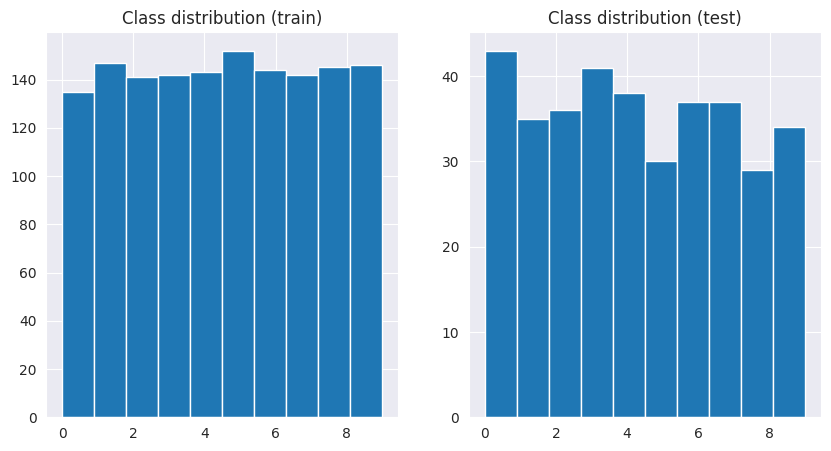

In [118]:
def split_data(data):
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=1)
    return X_train, y_train, X_test, y_test

# Graph the split data:
X_train, y_train, X_test, y_test = split_data(data)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(y_train)
ax[0].set_title('Class distribution (train)')
ax[1].hist(y_test)
ax[1].set_title('Class distribution (test)')
plt.show()

**calculate_class_probabilities**: This function calculates the prior probabilities of each class based on the training set. It takes X_train and y_train as input and returns an array class_probabilities containing the prior probabilities of each class.

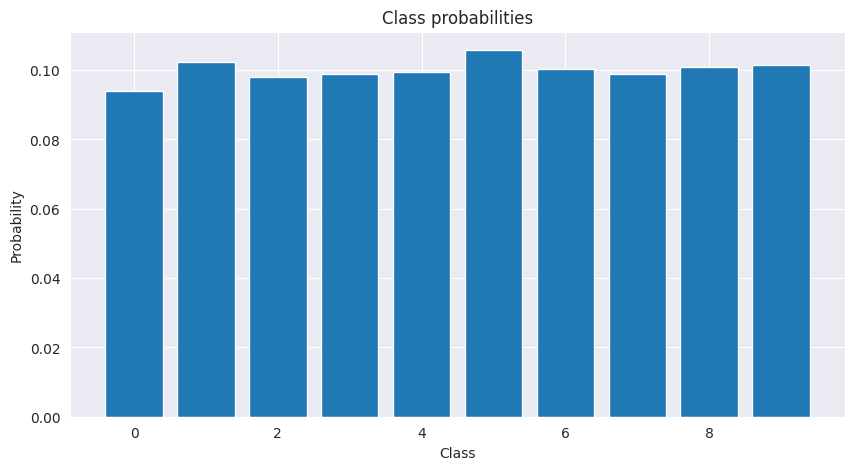

In [119]:
def calculate_class_probabilities(X_train, y_train):
    n_samples, n_features = X_train.shape
    classes = np.unique(y_train)
    n_classes = len(classes)
    class_probabilities = np.zeros(n_classes)
    for i in range(n_classes):
        class_i = classes[i]
        X_train_i = X_train[y_train == class_i]
        class_probabilities[i] = len(X_train_i) / n_samples
    return class_probabilities

# Graph the class probabilities:
class_probabilities = calculate_class_probabilities(X_train, y_train)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.bar(np.arange(10), class_probabilities)
ax.set_title('Class probabilities')
ax.set_xlabel('Class')
ax.set_ylabel('Probability')
plt.show()

**calculate_likelihood**: This function calculates the likelihood of a given feature value for a given class. It takes as input the feature value x, the mean and standard deviation of the feature values for the class, and returns the likelihood.

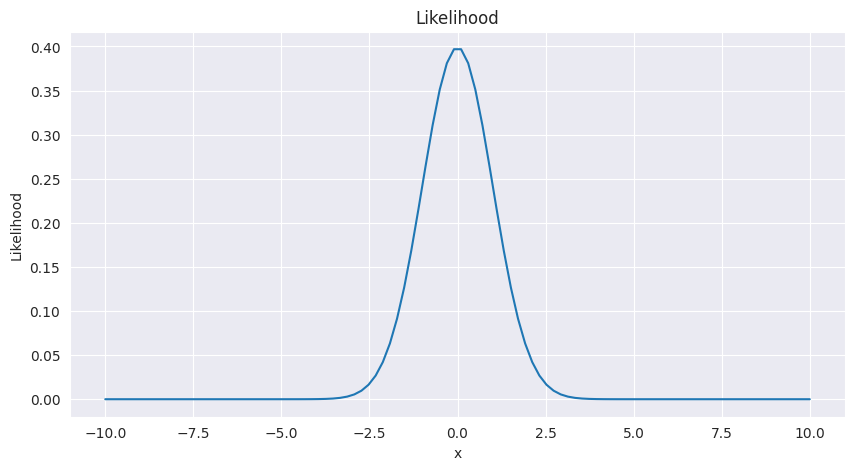

In [120]:
def calculate_likelihood(x, mean, std):
    exponent = np.exp(-((x-mean)**2 / (2 * std**2)))
    likelihood = (1 / (np.sqrt(2 * np.pi) * std)) * exponent
    return likelihood

# Graph the likelihood:
x = np.linspace(-10, 10, 100)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(x, calculate_likelihood(x, 0, 1))
ax.set_title('Likelihood')
ax.set_xlabel('x')
ax.set_ylabel('Likelihood')
plt.show()

**calculate_prior_likelihood**: This function calculates the prior likelihood of a given feature vector for each class based on the training set. It takes as input the feature vector x, X_train, and y_train, and returns an array prior_likelihood containing the prior likelihood of the feature vector for each class.

In [121]:
def calculate_prior_likelihood(x, X_train, y_train):
  n_samples, n_features = X_train.shape
  classes = np.unique(y_train)
  n_classes = len(classes)
  prior_likelihood = np.zeros(n_classes)
  for i in range(n_classes):
      class_i = classes[i]
      X_train_i = X_train[y_train == class_i]
      mean = np.mean(X_train_i, axis=0)
      std = np.std(X_train_i, axis=0)
      likelihood = calculate_likelihood(x, mean, std)
      prior_likelihood[i] = np.prod(likelihood)
  return prior_likelihood

**predict_class**: This function predicts the class of a given feature vector based on the prior likelihoods and class probabilities. It takes as input the feature vector x, class_probabilities, X_train, and y_train, and returns the predicted class.

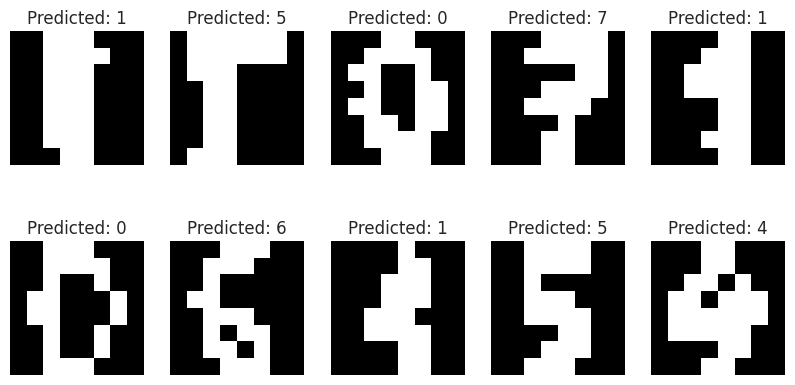

In [122]:
def predict_class(x, class_probabilities, X_train, y_train):
    prior_likelihood = calculate_prior_likelihood(x, X_train, y_train)
    posterior = prior_likelihood * class_probabilities
    return np.argmax(posterior)

# Graph the prediction of the first 10 digits:
fig, ax = plt.subplots(2, 5, figsize=(10, 5))
for i in range(10):
    ax[i // 5, i % 5].imshow(X_test.iloc[i, :].values.reshape(8, 8), cmap='gray')
    ax[i // 5, i % 5].set_title('Predicted: {}'.format(predict_class(X_test.iloc[i, :], class_probabilities, X_train, y_train)))
    ax[i // 5, i % 5].axis('off')
plt.show()

**predict**: This function predicts the class of multiple feature vectors based on the prior likelihoods and class probabilities. It takes as input X, class_probabilities, X_train, and y_train, where X is a matrix containing multiple feature vectors, and returns an array y_pred containing the predicted class of each feature vector.

In [123]:
def predict(X, class_probabilities, X_train, y_train):
    y_pred = []
    for i in range(len(X)):
        x = X.iloc[i]
        y_pred.append(predict_class(x, class_probabilities, X_train, y_train))
    return y_pred

**confusion_matrix**: This function computes the confusion matrix based on the actual and predicted labels. It takes as input actual and predicted, which are arrays containing the actual and predicted labels, and returns a matrix cm containing the confusion matrix.

In [124]:
def confusion_matrix(actual, predicted):
    unique_values = np.unique(actual)
    num_classes = len(unique_values)
    cm = np.zeros((num_classes, num_classes))
    for i in range(num_classes):
        actual_i = actual == unique_values[i]
        for j in range(num_classes):
            predicted_j = predicted == unique_values[j]
            cm[i, j] = np.sum(actual_i & predicted_j)
    return cm

**accuracy**: This function computes the accuracy of the model based on the confusion matrix. It takes as input cm, which is the confusion matrix, and returns the accuracy.

In [125]:
def accuracy(cm):
    diagonal_sum = cm.trace()
    sum_of_all_elements = cm.sum()
    return diagonal_sum / sum_of_all_elements

The main code uses the defined functions to split the data into training and testing sets, calculates the class probabilities based on the training set, predicts the class of the testing set, computes the confusion matrix, and prints the accuracy of the model.

Accuracy: 83.61%


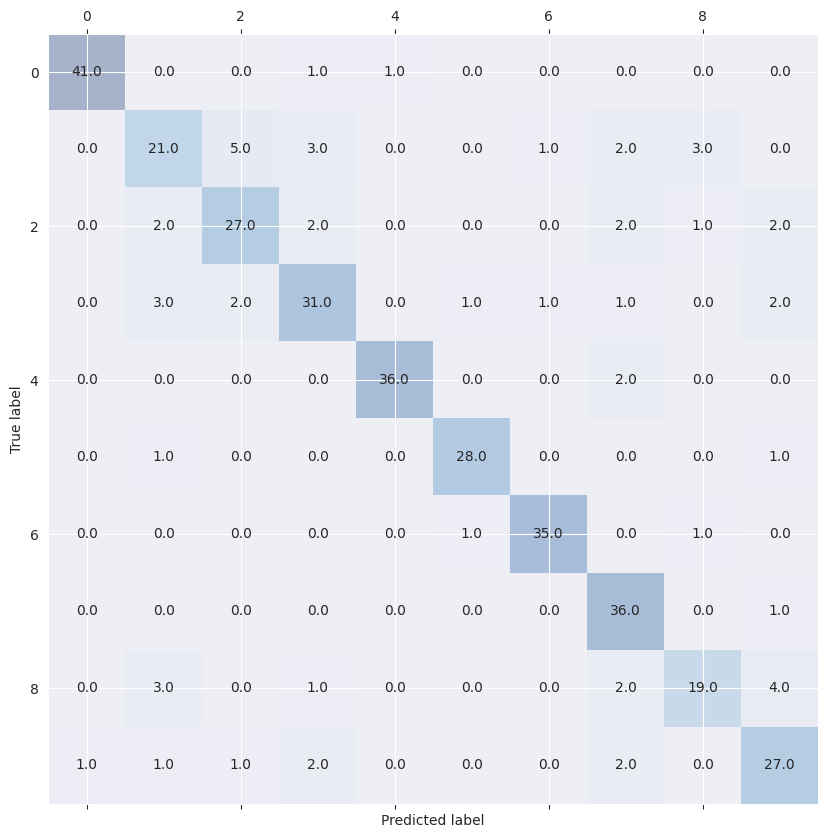

In [126]:
X_train, y_train, X_test, y_test = split_data(data)
class_probabilities = calculate_class_probabilities(X_train, y_train)
y_pred = predict(X_test, class_probabilities, X_train, y_train)
cm = confusion_matrix(y_test, y_pred)

# calculate accuracy
acc = accuracy(cm)
# Print as percentage
print('Accuracy: {:.2f}%'.format(acc * 100))

# Graph the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()